## NASA Temperature & Humidity Data Analysis for London

This file performs a detailed analysis of temperature and humidity data from NASA for the city of London. The main goals of this analysis are:

- **Data**: Import the temperature and humidity data for London.
- **VTT Model**: Fit the time series data into the original VTT model.
- **RCP Scenarios**: Consider RCP2.6, RCP4.5 and RCP8.5 to account for potential future climate changes.
- **Stochastic Optimization**: Employ stochastic optimization to provide a range of possible outcomes.
- **Mould Index Estimation**: Based on the above steps, output a mould growth index range for each RCP scenario.

By following these steps, we aim to understand the potential risks and outcomes related to mould growth in London under different climate change scenarios.


In [97]:
from scipy.integrate import cumtrapz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [98]:
data = pd.read_csv('Nasa_UK_21-22.csv')

In [99]:
# Adjust the temperatures for December to February
data['Date'] = pd.to_datetime(data['Date'])
# data.loc[data['Date'].dt.month.isin([12, 1, 2]), 'TS'] = 20

/var/folders/mt/9xr9vc1j62s6yvdx48jm0xlr0000gn/T/ipykernel_10642/3867394858.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


In [100]:
# Define the RCP scenario adjustments
percentage_of_century = 2/80

# RCP8.5
temp_increase_8_5 = 4.3 * percentage_of_century
humidity_increase_8_5 = temp_increase_8_5 * 5  # Assuming a 5% increase in humidity for each degree Celsius increase in temperature

# RCP4.5
temp_increase_4_5 = 2.5 * percentage_of_century
humidity_increase_4_5 = temp_increase_4_5 * 5

# RCP2.6 (assuming minimal changes)
temp_increase_2_6 = 0
humidity_increase_2_6 = 0

# Adjust the data for each RCP scenario
data_8_5 = data.copy()
data_8_5['TS'] += temp_increase_8_5
data_8_5['RH2M'] += humidity_increase_8_5

data_4_5 = data.copy()
data_4_5['TS'] += temp_increase_4_5
data_4_5['RH2M'] += humidity_increase_4_5

data_2_6 = data.copy()  # No changes for RCP2.6

data_8_5.head(), data_4_5.head(), data_2_6.head()

(   YEAR  MO  DY       TS     RH2M       Date
 0  2021   1   1  20.1075  96.9175 2021-01-01
 1  2021   1   2  20.1075  95.9175 2021-01-02
 2  2021   1   3  20.1075  95.1575 2021-01-03
 3  2021   1   4  20.1075  95.5375 2021-01-04
 4  2021   1   5  20.1075  96.7875 2021-01-05,
    YEAR  MO  DY       TS     RH2M       Date
 0  2021   1   1  20.0625  96.6925 2021-01-01
 1  2021   1   2  20.0625  95.6925 2021-01-02
 2  2021   1   3  20.0625  94.9325 2021-01-03
 3  2021   1   4  20.0625  95.3125 2021-01-04
 4  2021   1   5  20.0625  96.5625 2021-01-05,
    YEAR  MO  DY    TS   RH2M       Date
 0  2021   1   1  20.0  96.38 2021-01-01
 1  2021   1   2  20.0  95.38 2021-01-02
 2  2021   1   3  20.0  94.62 2021-01-03
 3  2021   1   4  20.0  95.00 2021-01-04
 4  2021   1   5  20.0  96.25 2021-01-05)

In [101]:
# Define the function for RHcrit based on the provided formula
def compute_rh_crit(T):
    T = np.array(T)
    rh_crit = np.zeros_like(T)
    rh_crit[T <= 20] = -0.0026 * T[T <= 20]**3 + 0.160 * T[T <= 20]**2 - 3.13 * T[T <= 20] + 100.0
    rh_crit[T > 20] = 80
    return rh_crit

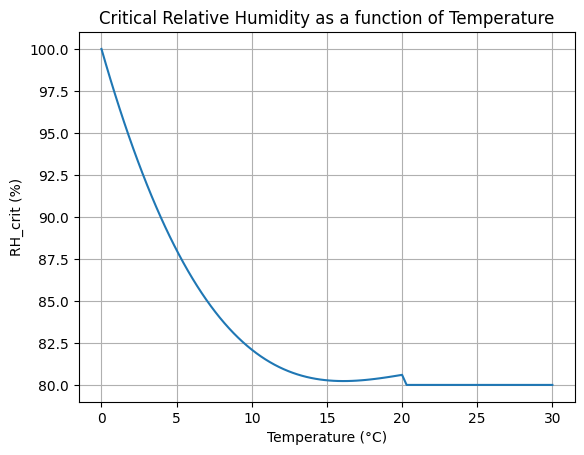

In [102]:
# Test the function with a range of temperatures
test_temperatures = np.linspace(0, 30, 100)
rh_crit_values = compute_rh_crit(test_temperatures)

plt.figure()
plt.plot(test_temperatures, rh_crit_values)
plt.xlabel('Temperature (°C)')
plt.ylabel('RH_crit (%)')
plt.title('Critical Relative Humidity as a function of Temperature')
plt.grid(True)
plt.show()

In [103]:
# Define the parameters
k11 = 0.578
k12 = 0.386
A = 0.3
B = 6
C = 1
p_T = 0.34*2
p_RH = 6.95*2
p_C = 33.01*2
W = 1
SQ = 1
C_decline = 1
t_1 = None

$$
RH_{\text{crit}} =
\begin{cases}
-0.0026T^3 + 0.160T^2 - 3.13T + 100.0 & \text{when } T(t) \leq 20 \\
80 & \text{when } T(t) > 20
\end{cases}
$$ (1)


$$
\frac{dM}{dt} = \frac{k_1k_2}{7* \exp\left(-p_T \ln(T) - p_{RH} \ln(RH) + 0.14W - 0.33SQ + p_C\right)} \quad \text{when } RH(t) \geq RH_{\text{crit}}(t)
$$ (2)


$$
\frac{dM}{dt} = C_{\text{decline}}
\begin{cases}
-0.032 & \text{when } t - t_1 \leq 6h \text{, or for nonwood surface }  \\
0 & \text{when } 6h < t - t_1 \leq 24h \\
-0.0016 & \text{when } t - t_1 > 24h
\end{cases}
\quad \text{when } RH(t) < RH_{\text{crit}}(t)
$$


For stochastic variations to simulate uncertainty:

- Let's vary the temperature by ±0.5°C around the adjusted value for each scenario.
- For humidity, we can vary it by ±5% relative to its adjusted value.

In [104]:
time = np.arange(len(data))

In [105]:
# Define the function to compute the mold growth index given a dataframe
def compute_mould_index(df):
    df['RHcrit'] = compute_rh_crit(df['TS'])

    # Initialize arrays for dM/dt and M
    dMdt = np.zeros(len(df))
    M = np.zeros(len(df))
    t_1 = None
    time = np.arange(len(df))

    # Iterate over the data to compute dM/dt and M
    for i in range(len(df)):
        M_max = A + B * (df.loc[i, 'RHcrit'] - df.loc[i, 'RH2M']) / (df.loc[i, 'RHcrit'] - 100) - C * ((df.loc[i, 'RHcrit'] - df.loc[i, 'RH2M']) / (df.loc[i, 'RHcrit'] - 100))**2
        k1 = k11 if M[i-1] < 1 else k12
        k2 = max(1 - np.exp(2.3 * (M[i-1] - M_max)), 0)
        if df.loc[i, 'RH2M'] < df.loc[i, 'RHcrit'] and t_1 is None:
            t_1 = time[i]
        elapsed_time = (time[i] - t_1) * 24 if t_1 is not None else 0
        if df.loc[i, 'RH2M'] < df.loc[i, 'RHcrit']:
            if elapsed_time <= 6:
                dMdt[i] = -0.032 * C_decline
            elif elapsed_time <= 24:
                dMdt[i] = 0
            elif elapsed_time > 24:
                dMdt[i] = -0.0016 * C_decline
        else:
            dMdt[i] = (k1 * k2 / 7) * np.exp(-p_T * np.log(df.loc[i, 'TS']) - p_RH * np.log(df.loc[i, 'RH2M']) + 0.14 * W - 0.33 * SQ + p_C)
            t_1 = None
        M[i] = M[i-1] + dMdt[i] if i > 0 else 0

    df['dMdt'] = dMdt
    df['M'] = M

    return df

In [106]:
# Stochastic optimization for all RCP scenarios
num_variations = 50
results_8_5 = []
results_4_5 = []
results_2_6 = []

for _ in range(num_variations):
    # RCP8.5
    variation_df = data_8_5.copy()
    variation_df['TS'] += np.random.uniform(-0.5, 0.5)
    variation_df['RH2M'] += np.random.uniform(-5, 5)
    results_8_5.append(compute_mould_index(variation_df))

    # RCP4.5
    variation_df = data_4_5.copy()
    variation_df['TS'] += np.random.uniform(-0.5, 0.5)
    variation_df['RH2M'] += np.random.uniform(-5, 5)
    results_4_5.append(compute_mould_index(variation_df))

    # RCP2.6
    variation_df = data_2_6.copy()
    variation_df['TS'] += np.random.uniform(-0.5, 0.5)
    variation_df['RH2M'] += np.random.uniform(-5, 5)
    results_2_6.append(compute_mould_index(variation_df))

These are the default parameter from the original VTT model

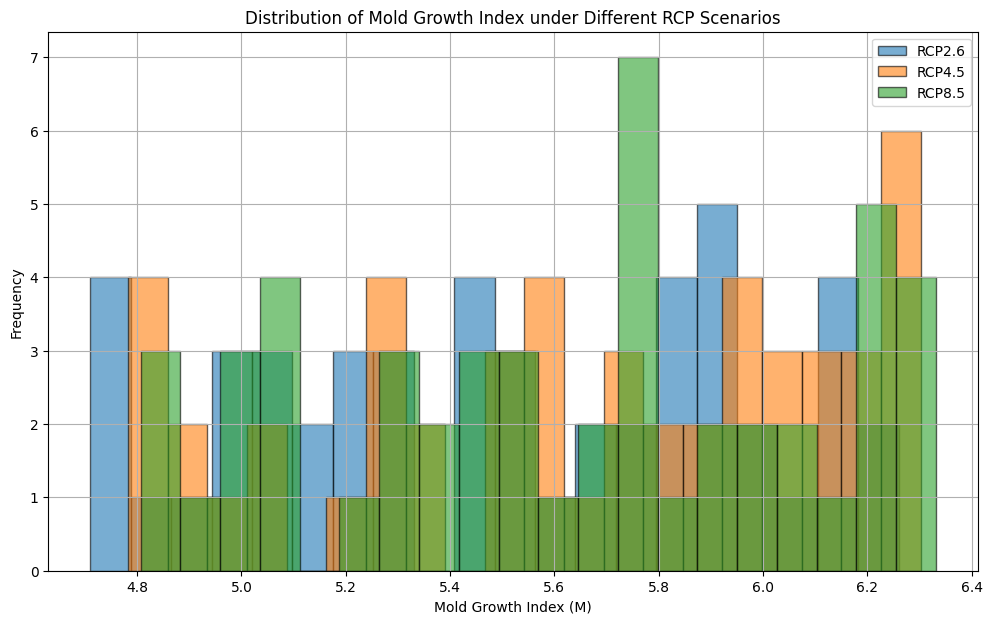

In [107]:
# Plotting results
plt.figure(figsize=(12, 7))
plt.hist([df['M'].iloc[-1] for df in results_2_6], bins=20, edgecolor='black', alpha=0.6, label='RCP2.6')
plt.hist([df['M'].iloc[-1] for df in results_4_5], bins=20, edgecolor='black', alpha=0.6, label='RCP4.5')
plt.hist([df['M'].iloc[-1] for df in results_8_5], bins=20, edgecolor='black', alpha=0.6, label='RCP8.5')
plt.title('Distribution of Mold Growth Index under Different RCP Scenarios')
plt.xlabel('Mold Growth Index (M)')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

In [108]:
# new_data = pd.read_csv('UoR_Data.csv')
# new_data = new_data.drop(0).reset_index(drop=True)
# new_data['Td'] = 20
# data = new_data
# data.rename(columns={'Td': 'TS'}, inplace=True)
# data.rename(columns={'RH': 'RH2M'}, inplace=True)
# data.rename(columns={'TimeStamp': 'Date'}, inplace=True)
# data['TS'] = pd.to_numeric(data['TS'], errors='coerce')
# data['RH2M'] = pd.to_numeric(data['RH2M'], errors='coerce')
# data.head()